<a href="https://colab.research.google.com/github/maritverboom/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment 


In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

## Data Loading

In [196]:
from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Splitting the data in train- and testpart with a portion of 'test_size' training data (20%)
data_train, data_test = model_selection.train_test_split(data, test_size=0.20, stratify=data['label'])

print(f'The number of rows of train data : {len(data_train.index)}')
print(f'The number of rows of test data : {len(data_test.index)}')

# seperate the data in features and tumorstage
stage_train = data_train['label']          # dataframe containing tumor stadium of subject (T12/T34)
stage_test = data_test['label'] 
data_train = data_train.drop(columns='label') # dataframe containing all feature columns except 'label' (tumor stadium of subject)
data_test = data_test.drop(columns='label')

# Binarize label data
stage_train = preprocessing.label_binarize(stage_train, ['T12', 'T34'])
stage_train = [i[0] for i in stage_train]

stage_test = preprocessing.label_binarize(stage_test, ['T12', 'T34'])
stage_test = [i[0] for i in stage_test]



The number of samples: 113
The number of columns: 160
The number of rows of train data : 90
The number of rows of test data : 23


## Preprocessing

- column verdwijnt als >25% van de column een 0 bevat. Dit heb ik gedaan omdat het vervangen van alle 0 voor NaN me niet heel handig leek, omdat je die 0 soms wel wilt gebruiken als het echt als waarde voorkomt.
- we kunnen nog proberen om 'missende' waardes op te vullen met 'feature imputation' zoals besproken in het college van 26/03

In [197]:
# Imputation
#imp = SimpleImputer(missing_values=np.nan, strategy='median')
#imp.fit(data_train)
#data_train = imp.transform(data_train)
#data_test = imp.transform(data_test)

# Remove all columns where more than 25% of the values are 0.0
drop_cols_train = data_train.columns[(data_train == 0).sum() > 0.25*data_train.shape[1]]
drop_cols_test = data_test.columns[(data_train ==0).sum() > 0.25*data_train.shape[1]]
data_train.drop(drop_cols_train, axis = 1, inplace = True) 
data_test.drop(drop_cols_test, axis = 1, inplace = True)
print(f'The number of columns after preprocessing: {len(data_train.columns)}')
print(f'The number of columns after preprocessing: {len(data_test.columns)}')


# Remove all columns with no std
drop_std_train = data_train.columns[data_train.std() == 0]
drop_std_test = data_test.columns[data_train.std() == 0]
data_train.drop(drop_std_train, axis = 1, inplace = True) 
data_test.drop(drop_std_test, axis = 1, inplace = True)

print(f'TRAIN: The number of columns after preprocessing: {len(data_train.columns)}, and the number of rows: {len(data_train.index)}')
print(f'TEST: The number of columns after preprocessing: {len(data_test.columns)},  and the number of rows: {len(data_test.index)}')






The number of columns after preprocessing: 152
The number of columns after preprocessing: 152
TRAIN: The number of columns after preprocessing: 150, and the number of rows: 90
TEST: The number of columns after preprocessing: 150,  and the number of rows: 23


## Data Scaling

Overwegen welk van de onderstaande het beste is voor onze data! 

StandardScaler removes the mean and scales the data to unit variance.  cannot guarantee balanced feature scales in the presence of outliers.

MinMaxScaler rescales the data set such that all feature values are in the range [0, 1], very sensitive to outliers

Robust scaler. Unlike the previous scalers, the centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers.

Read more: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
 

In [0]:
# Scale the data (train on train set)
scaler = preprocessing.StandardScaler()   
scaler.fit(data_train)  

# Perform scaling on both train and testset
data_train_scaled = scaler.transform(data_train)
data_test_scaled = scaler.transform(data_test) 

## Feature selection/extraction

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.


Variabelen
- stratifiedKfold(x), x veranderen geeft hele andere uitkomsten
- step = x, x laten als 1!

! Dit gebruiken we nu nog niet


https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV

- Univariate testing: select best performing features based on statistical test: sklearn.feature_selection.SelectKBest()

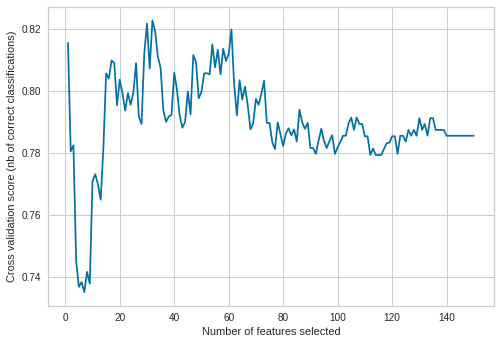

Num Features: 32
Selected Features: [False False  True False False False  True  True  True False False False
 False False False False False False False False False False  True False
  True  True False False False False False  True  True False False False
  True False False False  True False  True False False  True False False
 False False False False False False False False False  True False False
  True  True False False False False False False False False False False
 False False False  True False False False  True False False False  True
 False False  True  True False False False False False  True False False
  True False False False False  True False False False  True False False
 False  True False False False  True False False False False False False
  True False False False False False False False  True False False False
 False  True False False  True False False False  True False False False
 False False False False False False]
Feature Ranking: [ 39  47   1 105  63  83   1   1 

In [157]:
# Recursive Feature Elimination
svc = svm.SVC(kernel="linear")  # Create the RFE object and compute a cross-validated score.

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
fit = rfecv.fit(data_train_scaled, stage_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)


##  Feature selection using univariate feature selection

In [128]:
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
# X_new = SelectKBest(chi2, k=50).fit_transform(stage_train, data_train_scaled)
# print(X_new.shape)

selector = SelectPercentile(f_classif, percentile=10)
fit = selector.fit(data_train_scaled, stage_train)

print("Feature Ranking: %s" % fit.scores_)

Feature Ranking: [1.92621941e+01 1.43919207e+01 3.66873843e+00 3.92881145e-01
 1.23291576e+00 5.20369214e-01 4.28911472e+00 8.96613592e+00
 9.41768969e+00 3.15392037e+00 5.66166575e-01 9.90415330e-01
 3.35795269e-03 4.05645727e-02 2.17649245e+00 2.13255066e-02
 2.07037384e+00 3.72154769e+00 1.98702650e+00 2.12507529e+00
 4.31860112e-04 4.07269214e-01 5.23702575e-02 8.88185823e+00
 4.00717625e+00 1.90478758e+01 9.64140572e+00 6.19702218e-01
 1.06728516e+01 1.84352705e+00 1.40647877e+00 8.92604520e+00
 1.91803942e+01 7.10116842e-02 2.29430957e+00 1.30701846e+01
 9.04592736e+00 9.87890299e+00 2.29430957e+00 3.06018895e+01
 2.08664607e+01 2.07783729e+01 2.50877817e+01 1.68960539e+01
 1.39481083e+01 8.98706779e-01 9.08007350e+00 3.36785051e+00
 9.67489865e-01 5.25026678e-01 2.87037802e+00 2.08923787e+00
 5.07379509e+00 5.25026678e-01 2.09709156e+00 2.22037937e+00
 1.70588547e+00 1.91332210e+00 1.65333006e+00 2.82428117e+00
 1.03633959e+01 5.39151002e+00 7.56938324e-01 1.08924985e+00
 2.3264

## Principal Component Analysis (PCA)


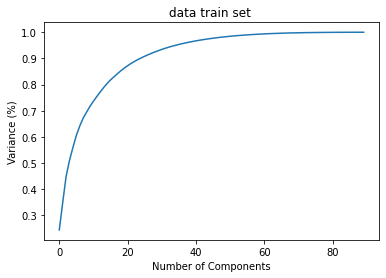

(90, 56)
(23, 56)


In [26]:

# Create a function for calculating PCA
def pca(data_train, data_test):
    """
    Function for PCA

        data_train = training data
        data_test = testing data

    Output is transformed train- and testdata
    """
    pca=PCA().fit(data_train)
    var = np.cumsum(pca.explained_variance_ratio_)
    n_comp = np.where(var>0.99)[0][0]

    pca_train = PCA(n_components=n_comp)
    pca_train.fit(data_train)

    # Transform data using PCA
    data_train_trans = pca_train.transform(data_train)
    data_test_trans = pca_train.transform(data_test)
    
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') # for each component
    plt.title('data train set ')
    plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

    # Return transformed train- and testdata
    return data_train_trans, data_test_trans

data_train_pca, data_test_pca = pca(data_train_scaled, data_test_scaled)
print(data_train_pca.shape)
print(data_test_pca.shape)



## Lasso feature selection


The optimal alpha = 0.038408036930858314
Selected 19 from 150 features.


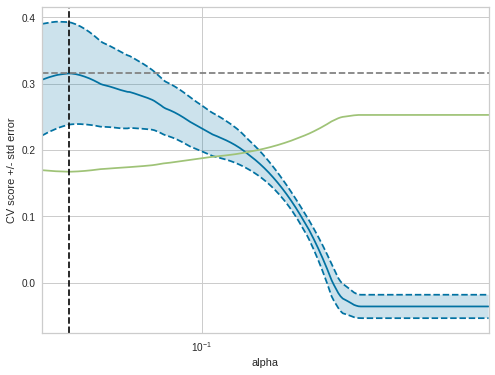

In [199]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import AlphaSelection
from yellowbrick.datasets import load_concrete
from sklearn.feature_selection import SelectFromModel


lasso = Lasso(max_iter=10000)
n_alphas = 200
alphas = np.logspace(-1.5, -0.1, n_alphas)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(data_train_scaled, stage_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(data_train_scaled, stage_train)
#visualizer.show()

alpha_best = model.alpha_
print(f'The optimal alpha = {alpha_best}')

#L1_selection = Lasso(alpha=alpha_best, max_iter=10000)
#L1_selection.fit(data_train_scaled, stage_train)
#train_score=L1_selection.score(data_train_scaled,stage_train)
#coeff_used = np.sum(L1_selection.coef_!=0)
#print("training score:", train_score) 
#print("number of features used: ", coeff_used)

selector = SelectFromModel(estimator=Lasso(alpha=alpha_best, random_state = 42))
selector.fit(data_train_scaled, stage_train)
n_original = data_train_scaled.shape[1]
data_train_l1 = selector.transform(data_train_scaled)
data_test_l1 = selector.transform(data_test_scaled)
n_selected = data_train_l1.shape[1]
print(f"Selected {n_selected} from {n_original} features.")



## kNN


In [200]:
# List with hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_n = list(range(1,50))
p=[1,2]
weights = ['uniform', 'distance']

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_n, p=p, weights = weights)

# Create new KNN object
knn_tune = neighbors.KNeighborsClassifier()

# Use Randomized Search
# Als je GridSearch gebruikt, komt er telkens hetzelfde uit. 
clf_tune_knn = model_selection.RandomizedSearchCV(knn_tune, hyperparameters, n_iter = 30, cv=10)
# Random state mag vgm niet, maar is de enige manier om ervoor te zorgen dat het constant dezelfde output geeft

#Fit the model
best_model = clf_tune_knn.fit(data_train_l1, stage_train)

leaf_size_best = best_model.best_estimator_.get_params()['leaf_size']
p_best = best_model.best_estimator_.get_params()['p']
n_n_best = best_model.best_estimator_.get_params()['n_neighbors']
weights_best = best_model.best_estimator_.get_params()['weights']


#Print The value of best Hyperparameters
print('Best leaf_size:', leaf_size_best)
print('Best p:', p_best)
print('Best n_neighbors:', n_n_best)
print('Best weights:', weights_best)

def knn_classifier(leaf_size, p, n_neigbors, weights, data_train, data_test, label_train, label_test):
    """
    Function for kNN training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    knn = neighbors.KNeighborsClassifier(leaf_size = leaf_size, weights = weights, n_neighbors = n_neigbors, p = p)
    knn.fit(data_train, label_train)
    label_train_knn = knn.predict(data_train)
    label_test_knn = knn.predict(data_test)
    score_train = knn.score(data_train, label_train)
    score_test = knn.score(data_test, label_test)
    return score_train, score_test, label_train_knn, label_test_knn

score_train_knn, score_test_knn, stage_train_knn, stage_test_knn = knn_classifier(leaf_size_best, p_best, n_n_best, weights_best, data_train_l1, data_test_l1, stage_train, stage_test)
print(f'Accuracy of classifier on traindata: {score_train_knn}') # accuracy
print(f'Accuracy of classifier on testdata: {score_test_knn}') # accuracy


Best leaf_size: 44
Best p: 1
Best n_neighbors: 11
Best weights: uniform
Accuracy of classifier on traindata: 0.8888888888888888
Accuracy of classifier on testdata: 0.782608695652174


## Support Vector Machine (SVM)
-  Geeft nu alleen een kernel mee, maar heeft nog veel meer parameters
- test_decision = svc.decision_function(data_test) kunnen we later miss nog gebruiken om een ROC te maken

In [202]:
# List with hyperparameters that we want to tune.
kernels = ['linear', 'poly', 'rbf']
gammas = [0.1, 1, 10, 100]
cs = [0.1, 1, 10, 100, 1000]
degrees = [0, 1, 2, 3, 4, 5, 6] # use only for 'poly'

hyperparameters = dict(kernel = kernels, gamma = gammas, C = cs, degree = degrees)

# Create new KNN object
svm_tune = svm.SVC()

# Use Randomized Search
# Als je GridSearch gebruikt, komt er telkens hetzelfde uit. 
clf_tune_svm = model_selection.RandomizedSearchCV(svm_tune, hyperparameters, n_iter = 30, cv=10)


#Fit the model
best_model_svm = clf_tune_svm.fit(data_train_l1, stage_train)

kernel_best = best_model_svm.best_estimator_.get_params()['kernel']
gamma_best = best_model_svm.best_estimator_.get_params()['gamma']
c_best = best_model_svm.best_estimator_.get_params()['C']
degree_best = best_model_svm.best_estimator_.get_params()['degree']

#Print The value of best Hyperparameters
print('Best kernel:', kernel_best)
print('Best gamma:', gamma_best)
print('Best C:', c_best)
print('Best degree:', degree_best)


def svm_classifier(C, kernel, degree, gamma, data_train, data_test, label_train, label_test, svm_kernel):
    """
    Function for SVM training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        svm_kernel = different kernels to be used (type = string)

    Output is two lists with the predicted class of the train- and testdata
    """
    svc = svm.SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
    svc.fit(data_train, label_train)

    # Predict the classes of the data 
    label_train_svm = svc.predict(data_train)
    label_test_svm= svc.predict(data_test)

    score_train = svc.score(data_train, label_train)
    score_test = svc.score(data_test, label_test)
    
    return label_train_svm, label_test_svm, score_train, score_test

stage_train_svm, stage_test_svm, score_train_svm, score_test_svm = svm_classifier(c_best, kernel_best, degree_best, gamma_best, data_train_l1, data_test_l1, stage_train, stage_test, 'linear')
print(f'Accuracy of classifier on traindata: {score_train_svm}') # accuracy
print(f'Accuracy of classifier on testdata: {score_test_svm}') # accuracy

Best kernel: linear
Best gamma: 100
Best C: 1
Best degree: 1
Accuracy of classifier on traindata: 0.9111111111111111
Accuracy of classifier on testdata: 0.6521739130434783


## Random Forest Classifier 
- alle parameters nog bepalen


In [0]:
def rfc_classifier(data_train, data_test, label_train, label_test):
    """
    Function for RFC training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    # Create Random Forest Classifier and fit classifier on traindata
    rfc = RandomForestClassifier(max_depth=2)
    rfc.fit(data_train, label_train)

    # Predict labels for train- and testdata
    label_train_rfc = rfc.predict(data_train)
    label_test_rfc = rfc.predict(data_test)

    return label_train_rfc, label_test_rfc

stage_train_rfc, stage_test_rfc = rfc_classifier(data_train_pca, data_test_pca, stage_train, stage_test)
print(stage_test_rfc)


[1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0]


## Performance
- Functie gemaakt om een dataframe te maken van de performance van een bepaalde classifier
- Uiteindelijke mooier om alles er tegelijk in te kunnen gooien met een loop en dan 1 groot dataframe te maken

In [0]:
def performance_clf(predlabel_train, label_train, predlabel_test, label_test):
    """
    Function to calculate performance of a classifier:

        predlabel_train = predicted label of traindata 
        label_train = real label of traindata
        predlabel_test = predicted label of testdata
        label_test = real label of testdata
    
    This function returns a dataframe of the calculated AUC, accuracy, F1-score,
    precision and recall of the classifier for the train- and testdata
    """
    
    # Performance train set
    auc_train=metrics.roc_auc_score(predlabel_train, label_train)
    accuracy_train=metrics.accuracy_score(predlabel_train, label_train)
    F1_train=metrics.f1_score(predlabel_train, label_train)
    precision_train=metrics.precision_score(predlabel_train, label_train)
    recall_train=metrics.recall_score(predlabel_train, label_train)
    
    # Performance test set
    auc_test=metrics.roc_auc_score(predlabel_test, label_test)
    accuracy_test=metrics.accuracy_score(predlabel_test, label_test)
    F1_test=metrics.f1_score(predlabel_test, label_test)
    precision_test=metrics.precision_score(predlabel_test, label_test)
    recall_test=metrics.recall_score(predlabel_test, label_test)

    performance = {'train': [auc_train, accuracy_train, F1_train, precision_train, recall_train],
                   'test': [auc_test, accuracy_test, F1_test, precision_test, recall_test]}
    frame_performance = pd.DataFrame(data=performance, index=['auc', 'accuracy', 'F1', 'precision', 'recall'])
  
    return frame_performance

performance_knn = performance_clf(stage_train_knn, stage_train, stage_test_knn, stage_test)
performance_svm = performance_clf(stage_train_svm, stage_train, stage_test_svm, stage_test)
performance_rfc = performance_clf(stage_train_rfc, stage_train, stage_test_rfc, stage_test)


print(f'The performance of the kNN-classifier is: {performance_knn}')
print(f'The performance of the SVM-classifier is: {performance_svm}')
print(f'The performance of the RFC-classifier is: {performance_rfc}')


The performance of the kNN-classifier is:               train      test
auc        0.740642  0.777778
accuracy   0.677778  0.652174
F1         0.743363  0.714286
precision  0.933333  1.000000
recall     0.617647  0.555556
The performance of the SVM-classifier is:               train      test
auc        0.855731  0.780303
accuracy   0.855556  0.782609
F1         0.853933  0.761905
precision  0.844444  0.800000
recall     0.863636  0.727273
The performance of the RFC-classifier is:               train      test
auc        0.922431  0.707692
accuracy   0.922222  0.695652
F1         0.923077  0.695652
precision  0.933333  0.800000
recall     0.913043  0.615385
